<a href="https://colab.research.google.com/github/Oka05286/2025_CV_TI2C/blob/main/Praktikum_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum D2

Langkah 1

In [ ]:
# Jalankan ini di awal notebook
from google.colab import files
files.upload() # pilih file kaggle.json dari komputer Anda

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"oksasetyarso","key":"6b0d41265b1565efec0a4c5305c6fcd7"}'}

Langkah 2

In [ ]:
import os, shutil
if os.path.exists("kaggle.json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
  os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
  !pip -q install kaggle
  print("✅ Kaggle API siap digunakan.")
else:
  print(" kaggle.json belum ditemukan. Upload terlebih dahulu.")

✅ Kaggle API siap digunakan.


Langkah 3

In [ ]:
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
✅ Dataset UTKFace berhasil diekstrak.


Total gambar ditemukan: 23708


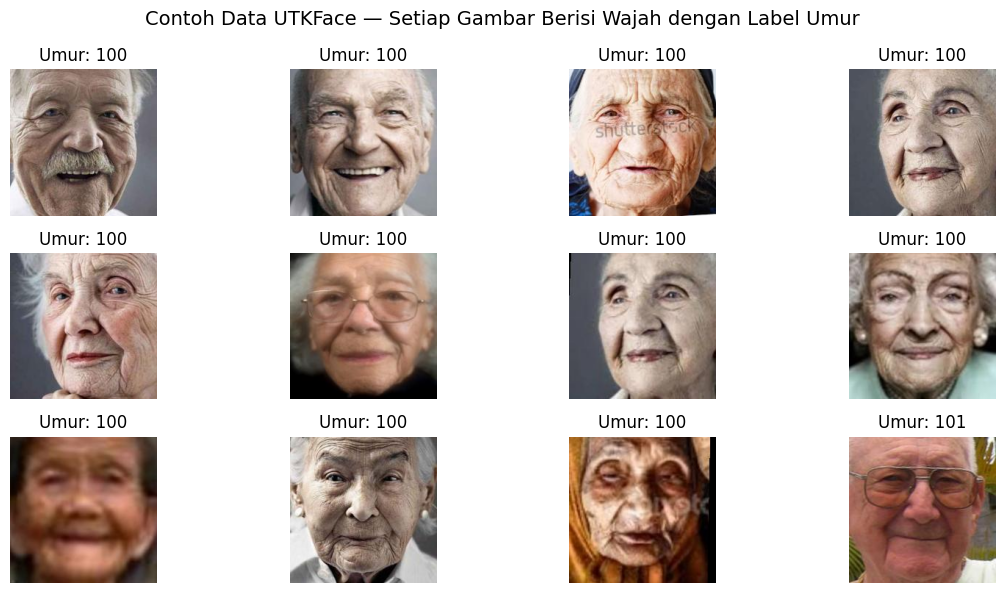

In [ ]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")
plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
  # Ambil umur dari nama file
  age = int(os.path.basename(f).split("_")[0])
  img = Image.open(f)
  plt.subplot(3, 4, i + 1)
  plt.imshow(img)
  plt.title(f"Umur: {age}")
  plt.axis("off")
plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()

Langkah 5

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
  return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(
    files, ages, test_size=0.2, random_state=42
)

IMG_SIZE = 160
def load_img(fp, label):
  img = tf.io.read_file(fp)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
  return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files,
y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files,
y_test)).map(load_img).batch(64)

print("✅ Dataset siap dilatih.")

✅ Dataset siap dilatih.


Langkah 6

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else
"CPU")

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
  include_top=False,
  input_shape=(IMG_SIZE, IMG_SIZE, 3),
  weights='imagenet'
)
base_model.trainable = False # tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x) # output tunggal: umur
model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='mse', metrics=['mae'])

model.summary()

Hardware: GPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Langkah 7

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 58s 131ms/step - loss: 367.4013 - mae: 14.0947 - val_loss: 159.7873 - val_mae: 9.6296 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 44s 48ms/step - loss: 157.2691 - mae: 9.3551 - val_loss: 149.8398 - val_mae: 9.2879 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 146.4891 - mae: 8.9189 - val_loss: 142.8540 - val_mae: 8.9434 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 139.7847 - mae: 8.7325 - val_loss: 140.0428 - val_mae: 8.8284 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 136.8323 - mae: 8.5877 - val_loss: 138.0279 - val_mae: 8.7204 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 135.2839 - mae: 8.5467 - val_loss: 135.6876 - val_mae: 8.6159 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 133.5430 - mae: 8.4679 - val_loss: 133.9914 - va

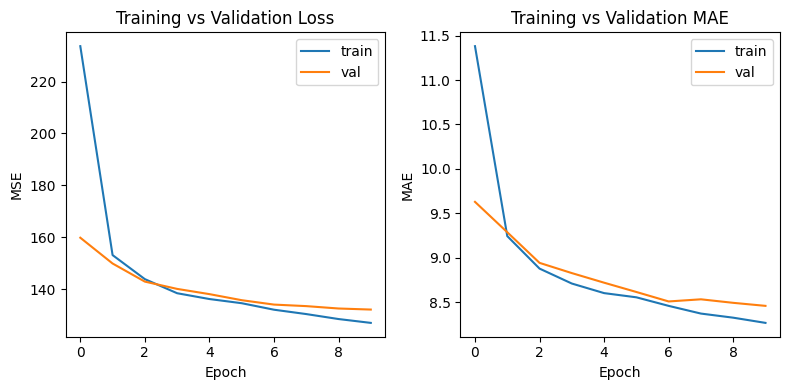

In [ ]:
# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()

Langkah 8

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 50s 110ms/step - loss: 185.9218 - mae: 10.0969 - val_loss: 140.8251 - val_mae: 9.0397 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 77.6962 - mae: 6.5950 - val_loss: 122.0646 - val_mae: 8.4295 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - loss: 51.5197 - mae: 5.4159 - val_loss: 117.2480 - val_mae: 8.3468 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 37.9726 - mae: 4.6727 - val_loss: 101.1039 - val_mae: 7.3515 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - loss: 29.3649 - mae: 4.1296 - val_loss: 100.1841 - val_mae: 7.3536 - learning_rate: 1.0000e-04


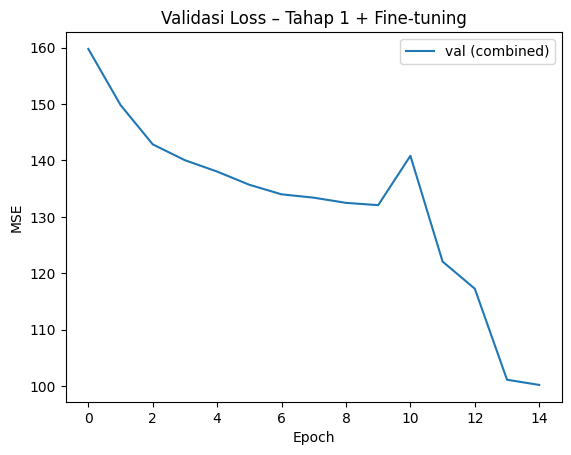

In [ ]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
  layer.trainable = False # beku sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='mse', metrics=['mae'])

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

# Visualisasi gabungan training dan fine-tuning:
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'],
label='val (combined)')
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.legend(); plt.show()

Langkah 9

MAE = 7.35 tahun
RMSE = 10.01 tahun
R2 = 0.748


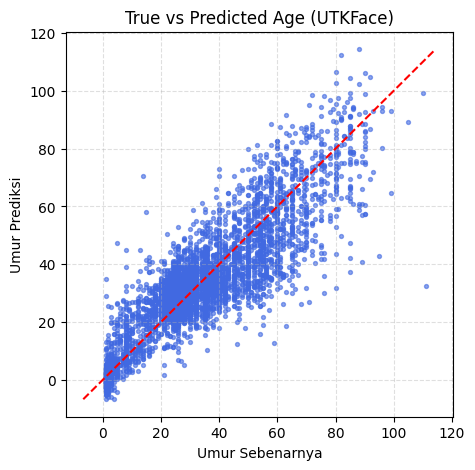

In [ ]:
from math import sqrt
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for
batch in test_ds])
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R2 = {r2:.3f}")

# Plot “umur sebenarnya vs umur prediksi”:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

Langkah 10

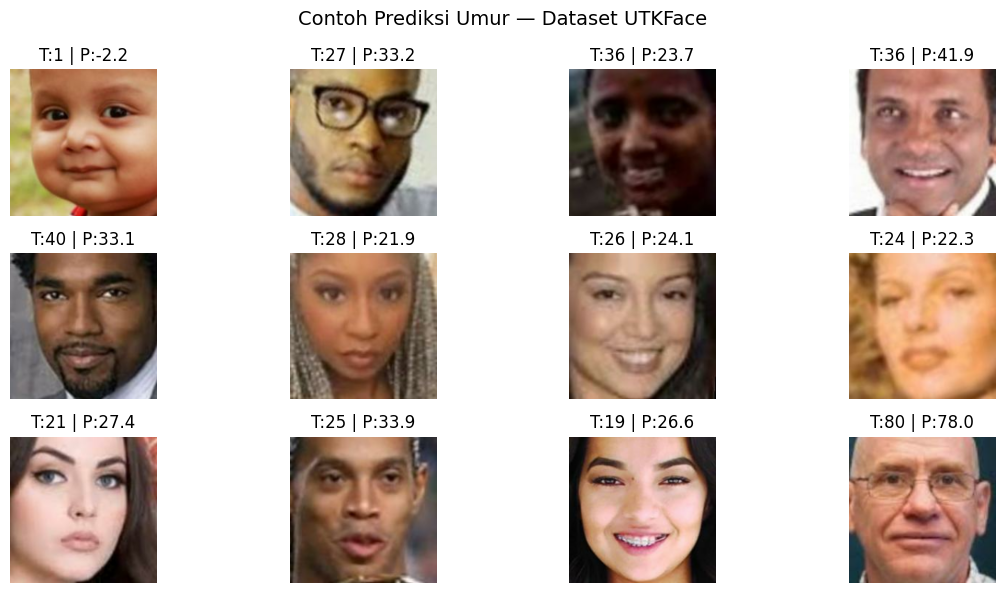

In [ ]:
import random
sample_paths = random.sample(test_files, 12)

plt.figure(figsize=(12,6))
for i, path in enumerate(sample_paths):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
  true_age = int(os.path.basename(path).split('_')[0])
  pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
  plt.subplot(3,4,i+1)
  plt.imshow(img.numpy())
  plt.title(f"T:{true_age} | P:{pred_age:.1f}")
  plt.axis('off')
plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()

# Praktikum D1

Setup & Generator Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
  r = np.random.randint(min_r, max_r + 1) # radius acak
  img = np.zeros((img_size, img_size), dtype=np.uint8)
  cx = np.random.randint(r, img_size - r) # center-x
  cy = np.random.randint(r, img_size - r) # center-y
  cv2.circle(img, (cx, cy), r, (255,), -1) # lingkaran putih terisi
  img = (img / 255.0).astype(np.float32)
  # 3-channel biar kompatibel CNN
  img3 = np.stack([img, img, img], axis=-1)
  return img3, float(r), (cx, cy)

“Tebak Apa?” — Tampilkan Contoh Gambar TANPA Label

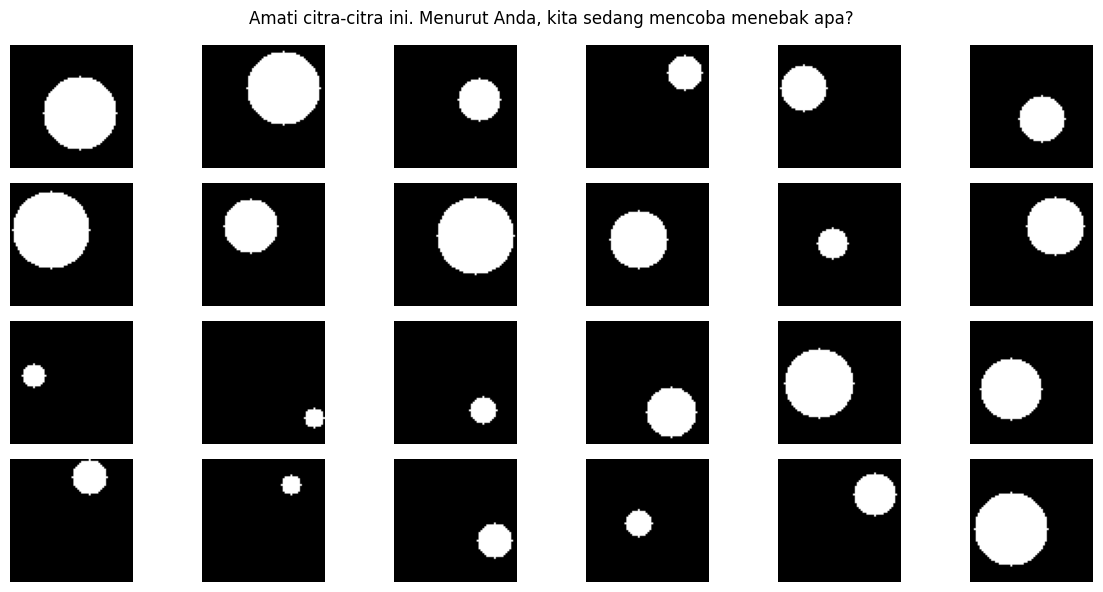

In [ ]:
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]
# Grid gambar tanpa label:
cols = 6
rows = N_show // cols
plt.figure(figsize=(12, 6))
for i in range(N_show):
  plt.subplot(rows, cols, i+1)
  plt.imshow(imgs[i].squeeze(), cmap='gray')
  plt.axis('off')
plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()

Buka Jawaban — Target yang Ingin Diprediksi

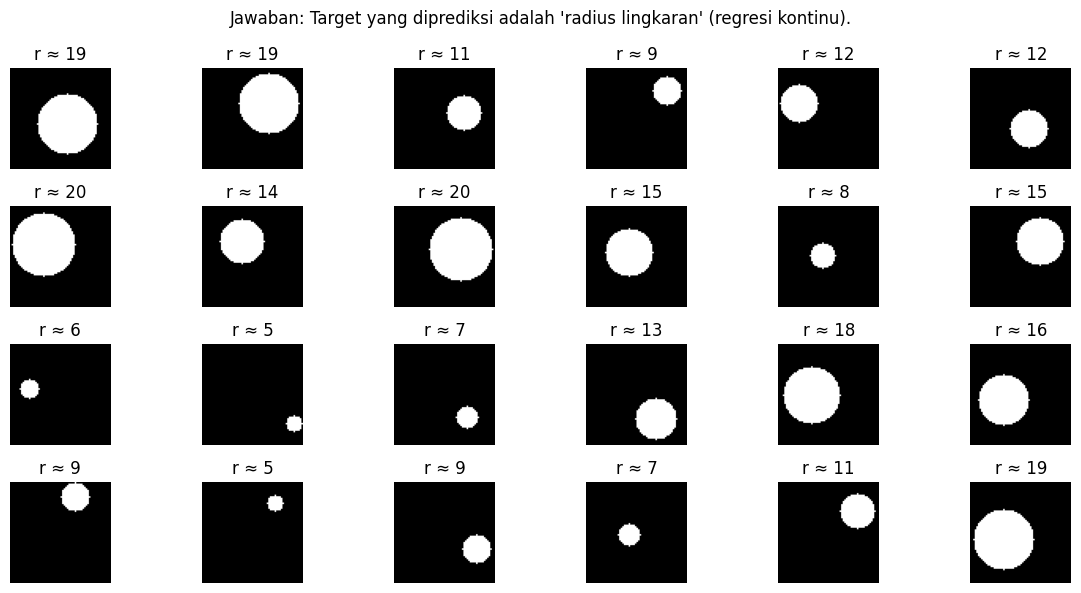

In [ ]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))
for i in range(N_show):
  plt.subplot(rows, cols, i+1)
  plt.imshow(imgs[i].squeeze(), cmap='gray')
  plt.title(f"r ≈ {int(rads[i])}")
  plt.axis('off')
plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).")
plt.tight_layout()
plt.show()

(Opsional) Latih CNN Kecil untuk Memprediksi Radius

In [ ]:
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
  layers.Input((64,64,3)),
  layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.GlobalAveragePooling2D(),
  layers.Dense(64, activation='relu'),
  layers.Dense(1) # output regresi
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
                    epochs=12, batch_size=64, verbose=0)

# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)
print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
MAE=0.933 | RMSE=1.156 | R2=0.935


Plot history & True vs Predicted:

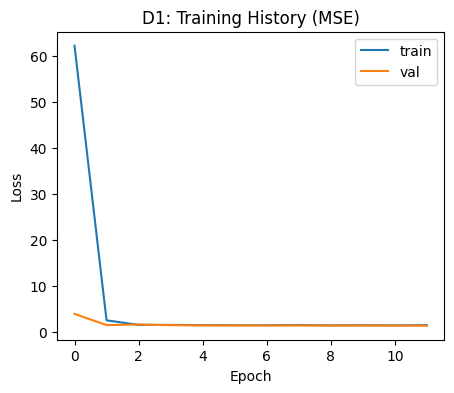

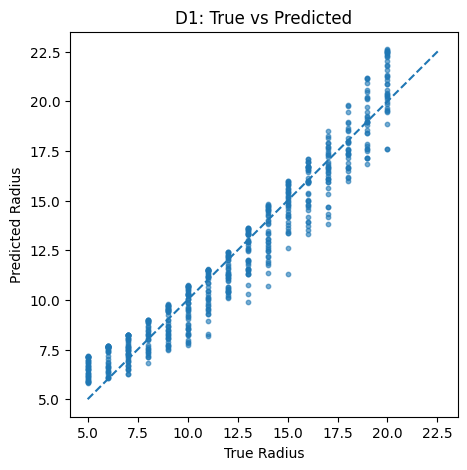

In [ ]:
# Plot loss
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# Scatter True vs Pred
plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius"); plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()

Tantangan Mini (Opsional untuk Mahasiswa)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,452,483 (9.36 MB)

 Trainable params: 2,452,483 (9.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 211.3576 - val_loss: 7.4996
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 18.4359 - val_loss: 3.7006
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 15.8960 - val_loss: 2.1277
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 15.5440 - val_loss: 2.2725
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 13.2323 - val_loss: 4.1628
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 12.8847 - val_loss: 2.1901
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 12.5365 - val_loss: 1.2062
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 12.3711 - val_loss: 1.5773
Epoch 9/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 11.9716 - val_loss: 1.7568
Epoch 10/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 11.3779 - val_loss: 3.6052
Epoch 11/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 10.2135 - val_loss: 0.7594
Epoch 12/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 10

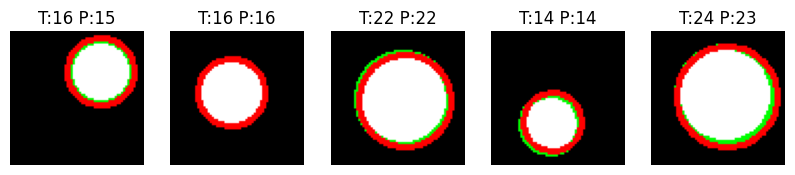

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Rentang (5, 15) → MAE=1.404, RMSE=2.732, R²=0.916
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Rentang (15, 35) → MAE=0.492, RMSE=0.654, R²=0.987
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Rentang (25, 45) → MAE=0.399, RMSE=0.526, R²=0.954
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Noise Gaussian+Blur → MAE=5.560, RMSE=6.538, R²=0.421


In [ ]:
# ==========================================================
# 🧠 Circle Radius Prediction (CNN + Tantangan Mini)
# ==========================================================
# Oksa Setyarso – versi pengembangan dari jobsheet
# ==========================================================

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import cv2

# ----------------------------------------------------------
# 1️⃣ Fungsi Pembuat Dataset Sintetis (lingkaran)
# ----------------------------------------------------------
def generate_circle_dataset(n_samples=2000, img_size=64, r_range=(8, 28), noise=False):
    X, y = [], []
    r_min, r_max = r_range

    # pastikan radius tidak lebih besar dari setengah ukuran gambar
    r_max = min(r_max, img_size // 2 - 2)
    r_min = max(2, r_min)

    for _ in range(n_samples):
        img = np.zeros((img_size, img_size), dtype=np.uint8)
        r = np.random.randint(r_min, r_max)
        cx, cy = np.random.randint(r, img_size - r, 2)

        cv2.circle(img, (cx, cy), r, 255, -1)

        if noise:
            noise_mat = np.random.normal(0, 25, (img_size, img_size))
            img = np.clip(img + noise_mat, 0, 255)
            img = cv2.GaussianBlur(img.astype(np.uint8), (5,5), 0)

        X.append(img)
        y.append([r, cx, cy])

    X = np.array(X).reshape(-1, img_size, img_size, 1) / 255.0
    y = np.array(y, dtype=np.float32)
    return X, y

# ----------------------------------------------------------
# 2️⃣ Buat Dataset
# ----------------------------------------------------------
X_train, y_train = generate_circle_dataset(3000, noise=False)
X_test, y_test = generate_circle_dataset(500, noise=False)

# ----------------------------------------------------------
# 3️⃣ Bangun Model CNN (Sedikit Lebih Kompleks)
# ----------------------------------------------------------
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='linear')  # output: [r, cx, cy]
])

model.compile(optimizer=Adam(1e-3), loss='mse')
model.summary()

# ----------------------------------------------------------
# 4️⃣ Latih Model
# ----------------------------------------------------------
es = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=32, callbacks=[es])

# ----------------------------------------------------------
# 5️⃣ Evaluasi Model
# ----------------------------------------------------------
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# ----------------------------------------------------------
# 6️⃣ Visualisasi Beberapa Prediksi
# ----------------------------------------------------------
plt.figure(figsize=(10, 3))
for i in range(5):
    idx = np.random.randint(0, len(X_test))
    img = X_test[idx].reshape(64,64)
    true_r, true_cx, true_cy = y_test[idx]
    pred_r, pred_cx, pred_cy = y_pred[idx]

    img_color = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    cv2.circle(img_color, (int(pred_cx), int(pred_cy)), int(pred_r), (0,255,0), 2)
    cv2.circle(img_color, (int(true_cx), int(true_cy)), int(true_r), (255,0,0), 2)

    plt.subplot(1,5,i+1)
    plt.imshow(img_color)
    plt.axis('off')
    plt.title(f"T:{int(true_r)} P:{int(pred_r)}")

plt.show()

# ==========================================================
# 🧩 Tantangan Mini – Eksperimen 1: Ubah Rentang Radius
# ==========================================================
for r_range in [(5,15), (15,35), (25,45)]:
    X_test2, y_test2 = generate_circle_dataset(500, r_range=r_range, noise=False)
    y_pred2 = model.predict(X_test2)
    mae2 = mean_absolute_error(y_test2, y_pred2)
    rmse2 = np.sqrt(mean_squared_error(y_test2, y_pred2))
    r22 = r2_score(y_test2, y_pred2)
    print(f"Rentang {r_range} → MAE={mae2:.3f}, RMSE={rmse2:.3f}, R²={r22:.3f}")

# ==========================================================
# 🧩 Tantangan Mini – Eksperimen 2: Tambah Noise
# ==========================================================
X_noise, y_noise = generate_circle_dataset(500, noise=True)
y_pred_noise = model.predict(X_noise)
mae_n = mean_absolute_error(y_noise, y_pred_noise)
rmse_n = np.sqrt(mean_squared_error(y_noise, y_pred_noise))
r2_n = r2_score(y_noise, y_pred_noise)
print(f"Noise Gaussian+Blur → MAE={mae_n:.3f}, RMSE={rmse_n:.3f}, R²={r2_n:.3f}")

# Praktikum D3

Langkah 1 — Menyiapkan Kaggle API

In [1]:
from google.colab import files
files.upload() # pilih kaggle.json dari komputer Anda
import os, shutil
if os.path.exists("kaggle.json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
  os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
  !pip -q install kaggle
  print("✅ Kaggle API siap digunakan.")
else:
  print(" kaggle.json belum ditemukan. Upload terlebih dahulu.")

Saving kaggle.json to kaggle.json
✅ Kaggle API siap digunakan.


Langkah 2 — Mengunduh dan Mengekstrak Dataset

In [2]:
# Unduh dataset Pawpularity (sekitar 800MB)
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("✅ Dataset Pawpularity berhasil diekstrak.")

403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/competitions/data/download-all/petfinder-pawpularity-score
unzip:  cannot find or open /content/petfinder-pawpularity-score.zip, /content/petfinder-pawpularity-score.zip.zip or /content/petfinder-pawpularity-score.zip.ZIP.
✅ Dataset Pawpularity berhasil diekstrak.


Langkah 3 — Melihat Contoh Data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
  img = Image.open(row.path)
  plt.subplot(3, 4, i + 1)
  plt.imshow(img)
  plt.title(f"Pawpularity: {row.Pawpularity}")
  plt.axis('off')
plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/paw/train.csv'